Aggregated data by driver saved to ../data/bulk_driver_aggregated_data.csv


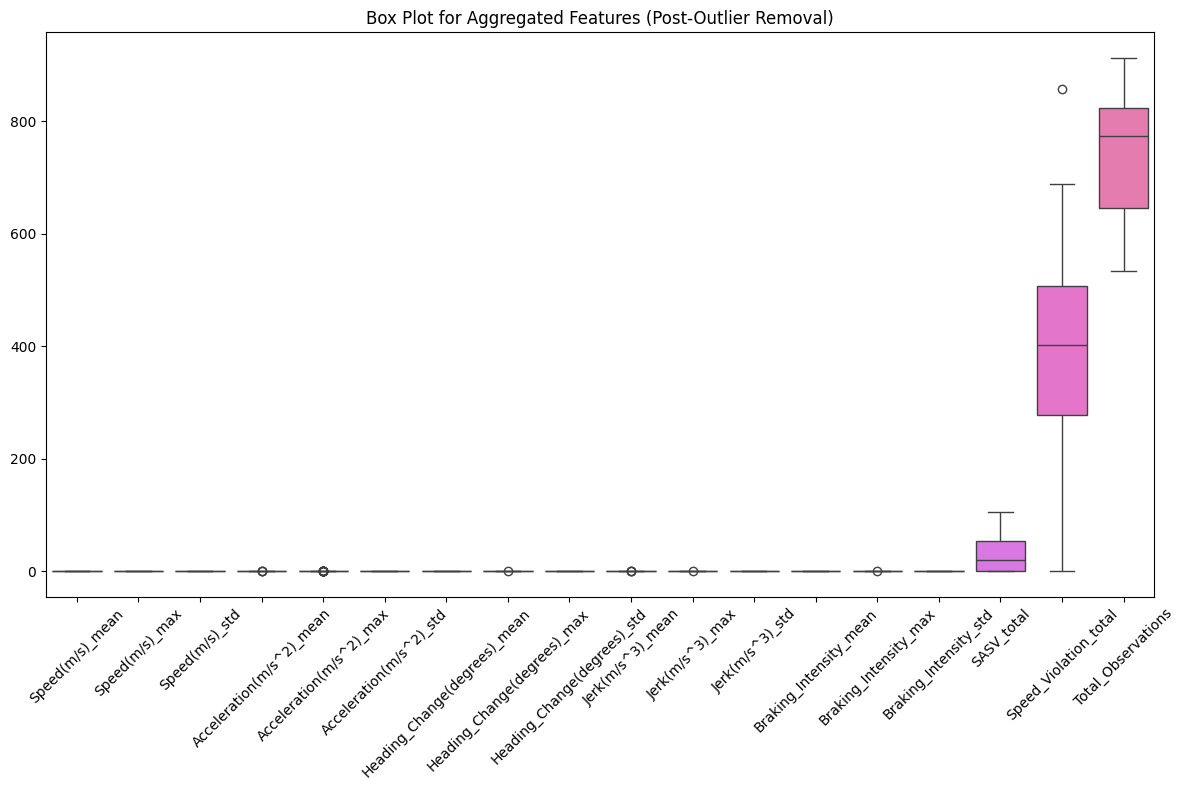

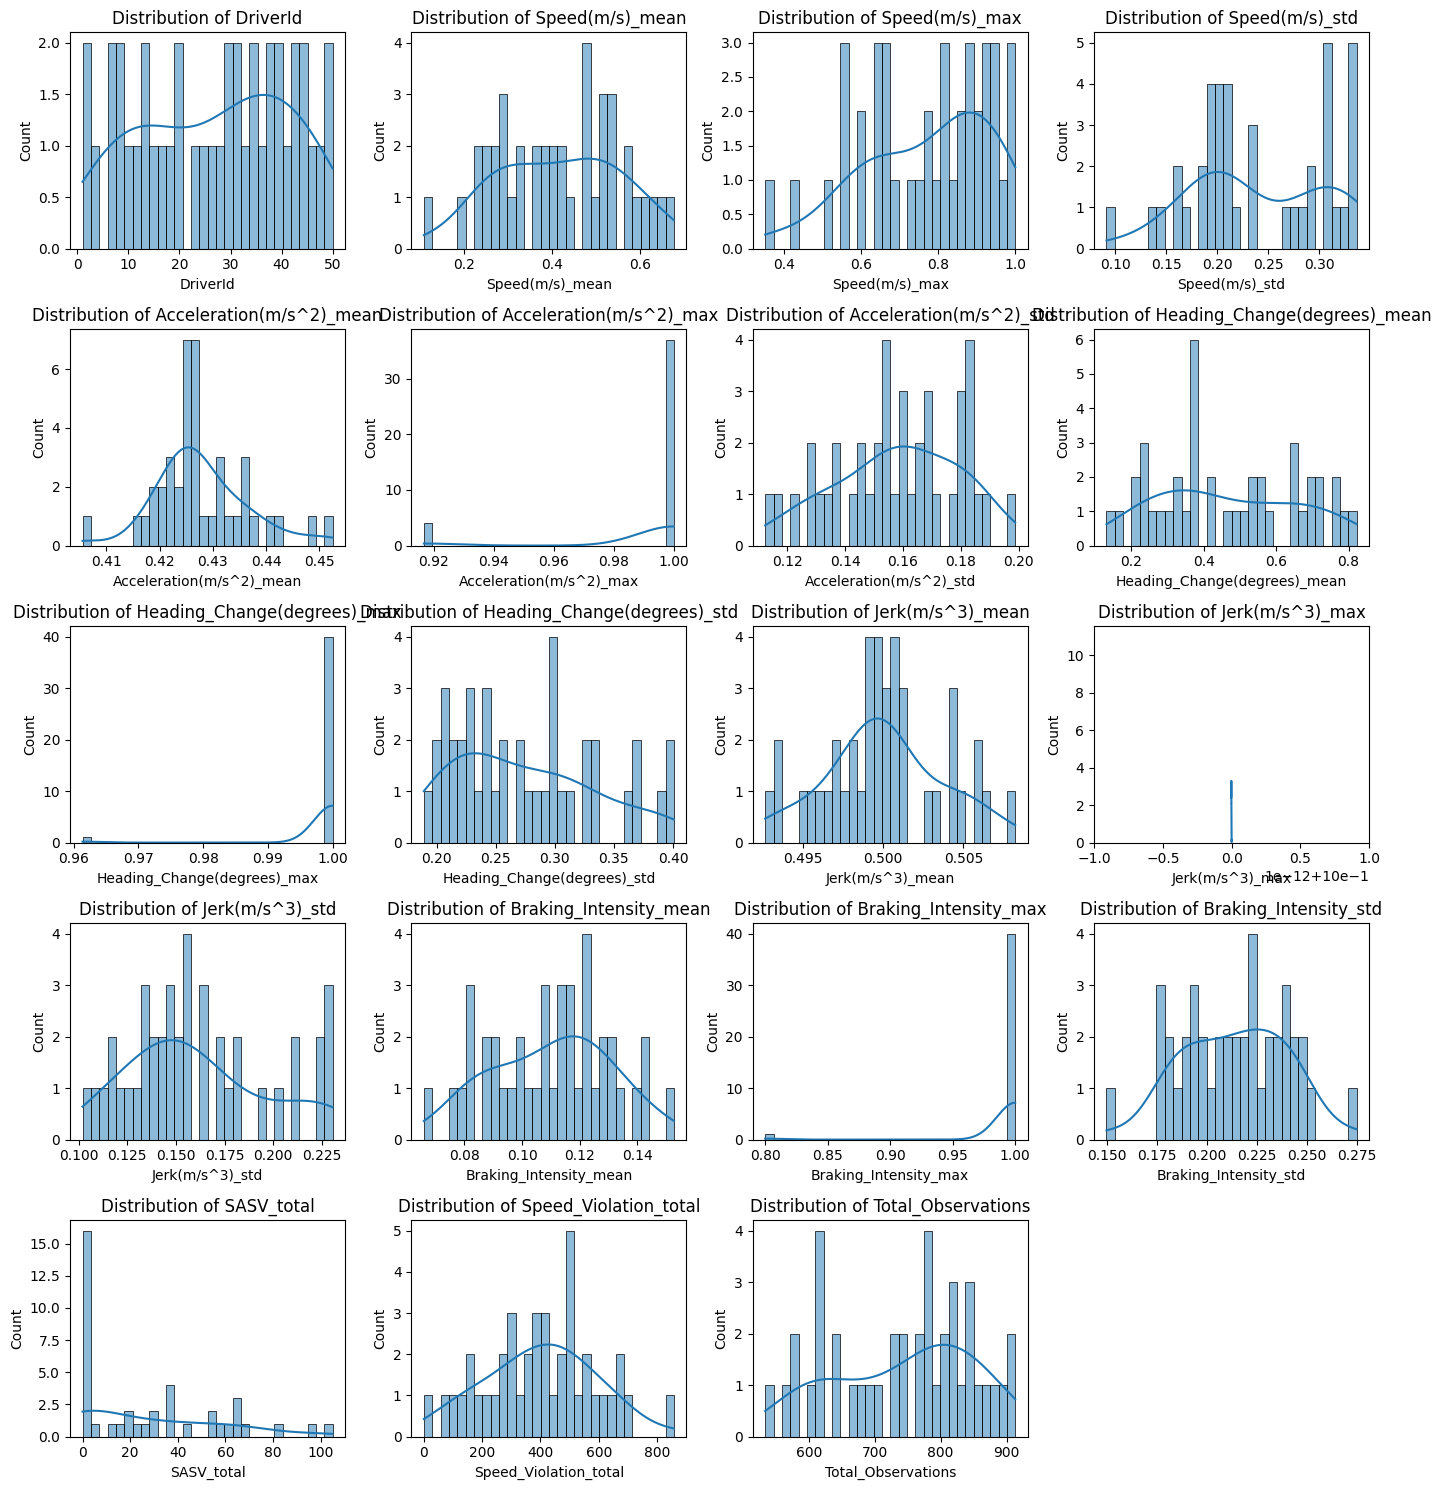

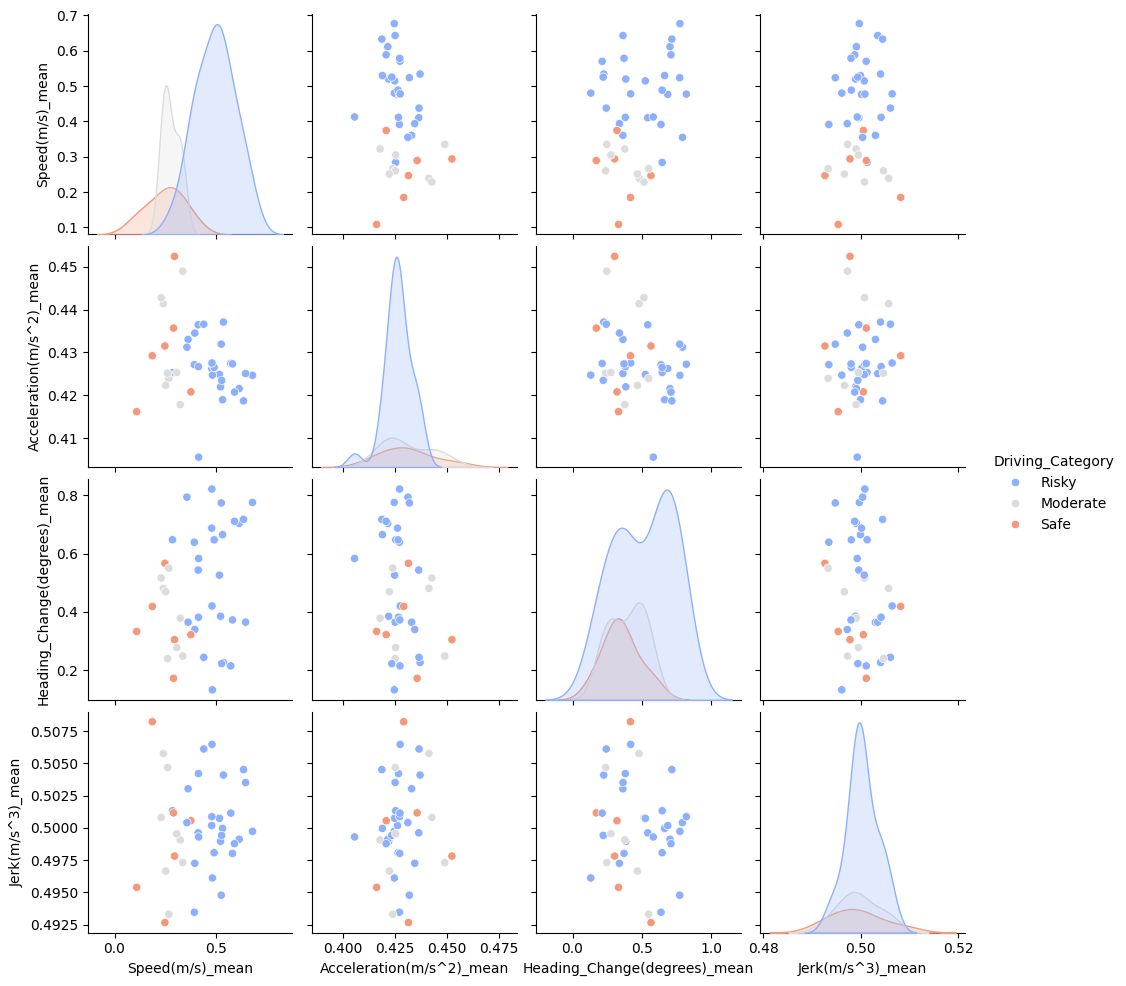

Cleaned and aggregated driver data saved to ../data/bulk_driver_aggregated_data.csv


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Ensure the 'data' directory exists
output_directory = '../data'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load the processed trip-level data
processed_data_path = '../data/processed_data.csv'
df = pd.read_csv(processed_data_path)

# Assign DriverId based on TripId (e.g., T-1 -> DriverId 1, T-2 -> DriverId 2)
df['DriverId'] = df['TripId'].apply(lambda x: int(x.split('-')[1]))

# Group by DriverId and aggregate data for each driver
driver_aggregated_data = df.groupby('DriverId').agg({
    'Speed(m/s)': ['mean', 'max', 'std'],
    'Acceleration(m/s^2)': ['mean', 'max', 'std'],
    'Heading_Change(degrees)': ['mean', 'max', 'std'],
    'Jerk(m/s^3)': ['mean', 'max', 'std'],
    'Braking_Intensity': ['mean', 'max', 'std'],
    'SASV': 'sum',  # Total SASV violations
    'Speed_Violation': 'sum',  # Total Speed violations
    'Time_Step': 'count',  # Total observations for the driver
    'Driving_Category': lambda x: x.mode()[0]  # Get the mode (most common category) for each driver
}).reset_index()

# Rename columns for clarity
driver_aggregated_data.columns = ['DriverId', 
                                  'Speed(m/s)_mean', 'Speed(m/s)_max', 'Speed(m/s)_std',
                                  'Acceleration(m/s^2)_mean', 'Acceleration(m/s^2)_max', 'Acceleration(m/s^2)_std',
                                  'Heading_Change(degrees)_mean', 'Heading_Change(degrees)_max', 'Heading_Change(degrees)_std',
                                  'Jerk(m/s^3)_mean', 'Jerk(m/s^3)_max', 'Jerk(m/s^3)_std',
                                  'Braking_Intensity_mean', 'Braking_Intensity_max', 'Braking_Intensity_std',
                                  'SASV_total', 'Speed_Violation_total', 'Total_Observations', 'Driving_Category']

# Save aggregated data for future bulk processing
aggregated_output_path = '../data/bulk_driver_aggregated_data.csv'
driver_aggregated_data.to_csv(aggregated_output_path, index=False)

print(f"Aggregated data by driver saved to {aggregated_output_path}")

# Outlier removal using Z-score for aggregated data
z_scores = np.abs(stats.zscore(driver_aggregated_data.select_dtypes(include=[np.number]).fillna(0)))
driver_aggregated_data = driver_aggregated_data[(z_scores < 3).all(axis=1)]  # Retain data within 3 std deviations

# ---------- Box Plot for Aggregated Data Features ---------- #
plt.figure(figsize=(12, 8))
sns.boxplot(data=driver_aggregated_data.select_dtypes(include=[np.number]).drop('DriverId', axis=1))
plt.title('Box Plot for Aggregated Features (Post-Outlier Removal)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_directory, 'aggregated_feature_boxplot.png'))
plt.show()

# ---------- Histograms for Aggregated Features ---------- #
numeric_columns = driver_aggregated_data.select_dtypes(include=[np.number]).columns

# Dynamically set the number of rows and columns based on the number of features
n_cols = 4  # Number of columns for the subplot grid
n_rows = np.ceil(len(numeric_columns) / n_cols).astype(int)  # Calculate the required number of rows

plt.figure(figsize=(14, n_rows * 3))  # Adjust the height of the figure dynamically
for idx, col in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(driver_aggregated_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig(os.path.join(output_directory, 'aggregated_feature_histograms.png'))
plt.show()

# ---------- Pair Plot to Visualize Relationships ---------- #
sns.pairplot(driver_aggregated_data, hue='Driving_Category', 
             vars=['Speed(m/s)_mean', 'Acceleration(m/s^2)_mean', 
                   'Heading_Change(degrees)_mean', 'Jerk(m/s^3)_mean'], 
             palette='coolwarm')
plt.savefig(os.path.join(output_directory, 'pairplot_driver_data.png'))
plt.show()

# Save the final cleaned and aggregated data
cleaned_output_path = '../data/bulk_driver_aggregated_data.csv'
driver_aggregated_data.to_csv(cleaned_output_path, index=False)

print(f"Cleaned and aggregated driver data saved to {cleaned_output_path}")
